**Задача: Обучить UNet сегментировать сгенерированные кружочки.**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

In [ ]:
warnings.simplefilter("ignore")

# Генерируем датасет

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

In [ ]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [ ]:
nx = 572
ny = 572

In [ ]:
generator = RgbDataProvider(nx, ny, cnt=20)

In [ ]:
x_train, y_train = generator(1)

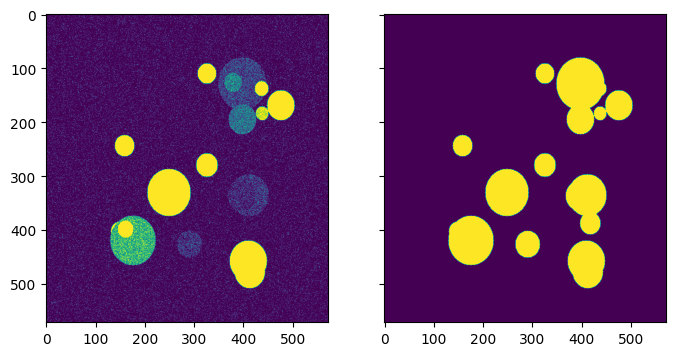

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_train[0,...,0], aspect="auto")
ax[1].imshow(y_train[0,...,1], aspect="auto")
plt.show()

In [ ]:
class PyTorchRGBDataProvider(torch.utils.data.Dataset):
    def __init__(self, nx, ny, num_samples, **kwargs):
        self.data_provider = RgbDataProvider(nx, ny, **kwargs)
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x, y = self.data_provider(1) # получить один элемент данных
        x = np.transpose(x[0,...], (2, 1, 0))
        y = np.transpose(y[0,...], (2, 1, 0))
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float()
        return x, y

In [ ]:
dataset = PyTorchRGBDataProvider(nx, ny, num_samples=500)

In [ ]:
dataset[1][0].shape

torch.Size([3, 572, 572])

In [ ]:
dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0919, 0.0090, 0.0000],
          [0.0000, 0.1076, 0.0654,  ..., 0.0000, 0.0348, 0.1845],
          [0.0000, 0.0000, 0.2212,  ..., 0.0000, 0.1069, 0.0000],
          ...,
          [0.4357, 0.0000, 0.1894,  ..., 0.3894, 0.0000, 0.0000],
          [0.0000, 0.1815, 0.0000,  ..., 0.0000, 0.0000, 0.2550],
          [0.0000, 0.0000, 0.0894,  ..., 0.0394, 0.0144, 0.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ...,

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size= 4, shuffle=True)

# Создание модели

**Unet**

Unet является архитектурой нейронной сети, предназначенной для семантической сегментации или сегментации изображений. Она была предложена в 2015 году и быстро стала одной из наиболее широко используемых моделей для решения задач сегментации.

Архитектура Unet получила свое название из-за своей особенной формы, которая напоминает букву "U". В основе Unet лежит кодировщик (encoder) и декодировщик (decoder), связанные между собой.

Кодировщик состоит из сверточных слоев, которые последовательно сжимают исходное изображение, уменьшая его размерность и извлекая более высокоуровневые признаки. В результате этой операции получается набор признаков меньшего размера, но с более высокой информативностью.

Декодировщик состоит из транспонированных сверточных слоев (также называемых слоями-распаковщиками или апсэмплинг слоями), которые увеличивают размерность признакового множества, восстанавливая исходную размерность изображения. Декодер связывается с кодировщиком путем добавления дополнительных сверточных слоев, которые соединяют информацию об уровнях кодировщика с соответствующими слоями декодировщика.

Важной особенностью Unet является сопоставление дополнительных признаковых карт на каждом уровне декодировщика с соответствующими картами кодировщика. Это делается путем конкатенации карт и применения сверточных операций к объединенным данным. Такой механизм позволяет сохранять детальную информацию о пространственной структуре изображения на разных масштабах.

Unet обучается при помощи метода обратного распространения ошибки и стандартного алгоритма оптимизации, такого как стохастический градиентный спуск. Обычно используется функция потерь, такая как перекрестная энтропия или коэффициент Дайса, для измерения расхождения между предсказанными и истинными сегментами.

В результате обучения Unet способна предсказывать сегментацию изображения, разделяя его на различные классы или регионы. Эта модель была успешно применена во многих областях, включая медицинское изображение, биологию, анализ снимков спутников и другие.



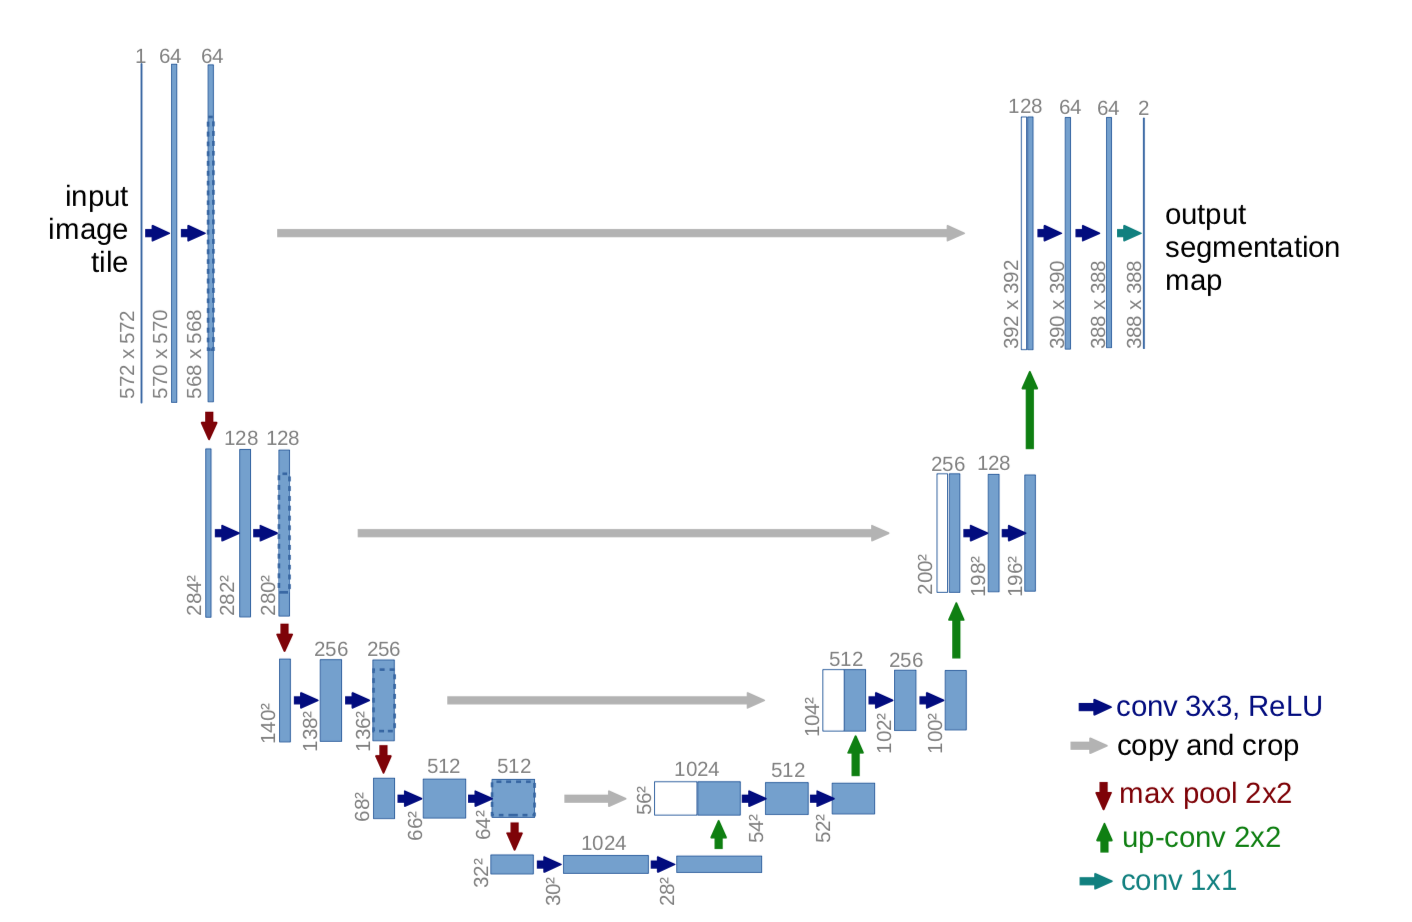

In [ ]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up2 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        x = self.dconv_down2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up2(x)
        out = self.conv_last(x)

        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_class=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Обучение модели

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Передний проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()
        print(f"\r{(int(i/len(dataloader)*100))+1}% ", end="", flush=True)
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}')

100% Epoch 1, Loss: 0.0901
100% Epoch 2, Loss: 0.0677
100% Epoch 3, Loss: 0.0625
100% Epoch 4, Loss: 0.1043
100% Epoch 5, Loss: 0.0806
100% Epoch 6, Loss: 0.0633
100% Epoch 7, Loss: 0.0766
100% Epoch 8, Loss: 0.0632
100% Epoch 9, Loss: 0.0637
100% Epoch 10, Loss: 0.0596


# Визуализация работы модели

In [ ]:
def visualize_segmentation(image, target, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi = 120)

    axes[0].imshow(image, aspect="auto")
    axes[0].set_title('Original Image')

    axes[1].imshow(target, aspect="auto")
    axes[1].set_title('Ground Truth Segmentation')

    axes[2].imshow(prediction, aspect="auto")
    axes[2].set_title('Predicted Segmentation')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
test_dataset = PyTorchRGBDataProvider(nx, ny, num_samples=1)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size= 1, shuffle=True)

In [ ]:
model.eval()
for X, masks in test_dataloader:
    X = X.cuda()
    output = model(X)
    break

In [ ]:
img_output = output[0, 0, :, :]

In [ ]:
mask = masks[0, 0, :, :]

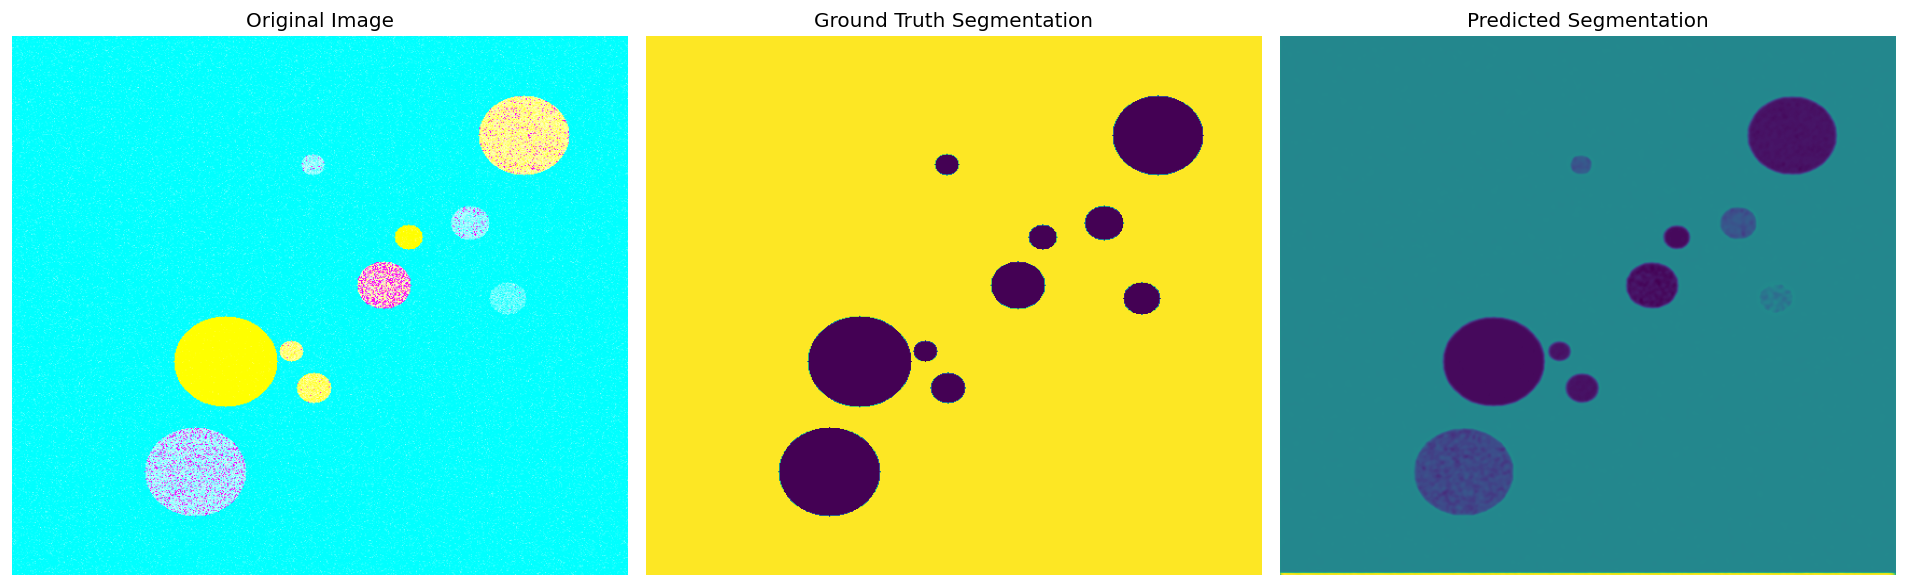

In [ ]:
visualize_segmentation(X[0,...].permute(1,2,0).cpu(), mask.detach().cpu(), img_output.detach().cpu())